In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets, transforms
# from torchvision.utils import save_image

import numpy as np
import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne



%aimport Dataset_QSH

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [2]:

import torch
import torch.utils.data
from torch import nn, optim
import torch.nn.functional as F
import brevitas.nn as qnn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


In [3]:
from models.torch.VAE import VAE

In [4]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x.view(-1, 30), reduction='sum')
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE #+ KLD


In [5]:
m = VAE(latent_dim=6, size=10)
x = torch.tensor(torch.randn([100,30]))
# F.mse_loss(x,m(x)[0].view(-1,30))
m(x)[0]


/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/torch/jit/_recursive.py:145: UserWarning: 'stats_reduce_dim' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/torch/jit/_recursive.py:145: UserWarning: 'const_affine_weight' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/torch/jit/_recursive.py:145: UserWarning: 'const_affine_bias' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to 

tensor([0.5598, 0.5207, 0.4211, 0.5678, 0.6094, 0.5055, 0.5462, 0.3606, 0.5297,
        0.5875, 0.4357, 0.4989, 0.3528, 0.5352, 0.4666, 0.4688, 0.6151, 0.6397,
        0.5783, 0.4986, 0.5391, 0.5030, 0.4073, 0.5624, 0.4334, 0.4797, 0.4124,
        0.4846, 0.4430, 0.5830], grad_fn=<SelectBackward>)

In [6]:
xy = torch.tensor(torch.randn([100,30]))
XY = m(xy)[0]
x,y = torch.split(XY, 15)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [7]:
qsh = Dataset_QSH.Dataset_QSH()
file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
qsh.load(file)

qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()

params = {
            'batch_size': 100,
            'shuffle': True,
            'num_workers': 6,
            'shuffle': True,
         }

ds = qsh.get_torch_dataset()
ds,ts = torch.utils.data.random_split(ds, [len(ds)-6000, 6000])

ds = DataLoader(ds,**params)
ts = DataLoader(ts,**params)


In [8]:
optimizer = optim.Adam(m.parameters(), lr=1e-3)

def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(ds):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        mu, logvar = model.get_params()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print("step: [{}], loss={}".format(batch_idx, loss.item()), end = '  \r')

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(ds)), end='\t' )

    
    
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(ts):
            data = data.to(device)
            recon_batch = model(data)
            mu, logvar = model.get_params()
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(ts)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [9]:
for e in range(50):
    train(m,e)
    test(m,e)

====> Epoch: 0 Average loss: 42.0123	 ====> Test set loss: 16.8059
====> Epoch: 1 Average loss: 9.1585	  ====> Test set loss: 3.5861
====> Epoch: 2 Average loss: 5.6380	  ====> Test set loss: 2.6642
====> Epoch: 3 Average loss: 4.3153	  ====> Test set loss: 3.1573
====> Epoch: 4 Average loss: 4.6253	  ====> Test set loss: 3.1145


KeyboardInterrupt: 

In [ ]:
for e in range(50):
    train(m,e)
    test(m,e)

In [31]:
ts_batch = [x for x in ts][0][0]
pos = 0

np.save('./vae_ckpt/ts_batch.npy', ts_batch.numpy())

In [14]:
m.eval()
m(ts_batch[0])

tensor([[0.0305, 0.0985, 0.1479, 0.1982, 0.2650, 0.3336, 0.4138, 0.4881, 0.5650,
         0.6404, 0.7212, 0.7783, 0.8221, 0.8681, 0.9217, 0.1123, 0.1440, 0.1580,
         0.1590, 0.1771, 0.1812, 0.1745, 0.1813, 0.1834, 0.1826, 0.1700, 0.1658,
         0.1661, 0.1526, 0.1405]], grad_fn=<SigmoidBackward>)

0


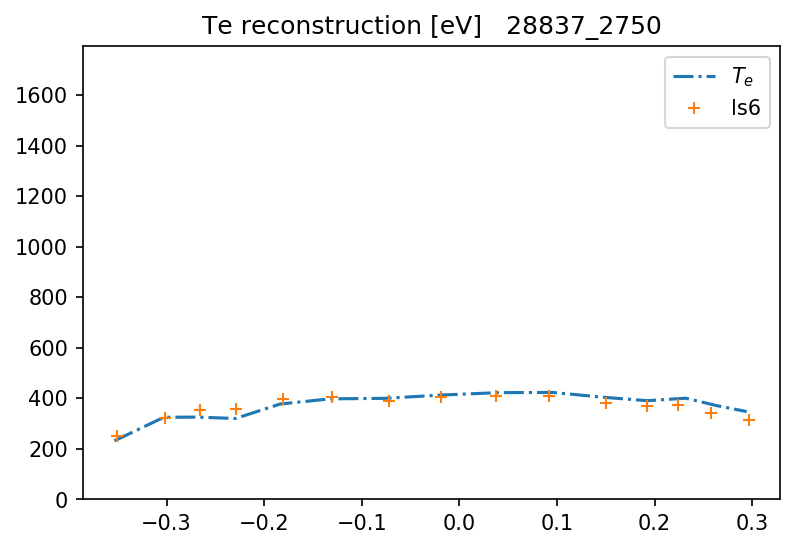

In [15]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook


print(pos)

def un(x, min=0., max=2242.511):
    return min + x*(max-min)

def unx(x, min=-0.373, max=0.353):
    return min + x*(max-min)

def plot_torch(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    x,y = torch.split(xy, 15, dim=0)
    plt.plot(unx(x),un(y),h, label=name)
    ax.legend()

    
def plot_te(vae, xy):    
    fig = plt.figure('plot')
    plt.clf()
    ax = plt.gca()
    ax.set_title( 'Te reconstruction [eV]   '+qsh[pos].label.decode("utf-8") )
    vae.eval()    
    XY = vae(xy)[0].detach()

    plot_torch(xy, '$T_e$','-.')
    plot_torch(XY, 'ls6','+')


plot_te(m, ts_batch[pos])
pos += 1



In [18]:
# m.eval()
# import brevitas.onnx as bo
# bo.export_finn_onnx(m,(1,30),'vae.onnx')

In [30]:
!mkdir -p ./vae_ckpt

In [22]:
## SAVING TORCH MODEL
# torch.save(m, './vae_model.pth')
checkpoints_dir_path = './vae_ckpt'
def checkpoint_best(model, optimizer, epoch):
    import os
    best_path = os.path.join(checkpoints_dir_path, "best.tar")
    print("Saving checkpoint model to {}".format(best_path))
    torch.save({
        'state_dict': model.state_dict(),
        'optim_dict': optimizer.state_dict(),
    }, best_path)

In [23]:
checkpoint_best(m,optimizer,0)

Saving checkpoint model to ./vae_ckpt/best.tar


In [ ]:
m2 = VAE(size=5)
cfg = torch.load(checkpoints_dir_path+'/best.tar')
m2.load_state_dict(cfg['state_dict'],strict=False)


In [ ]:
plot_te(m2, ts_batch[pos-1])

In [ ]:
!python3 -m pip install --user netron

In [ ]:
def start_netron(onnx_path, port=8081):
    try:
        import netron
        netron.start(export_onnx_path, port=port, host="0.0.0.0")
    except:
        print('faild to load netron')


In [ ]:
netron.start('/tmp/vae.onnx', port=8082)

In [ ]:
netron.stop()